In [1]:
import numpy as np
import GPy
from GPy.kern.src.kern import Kern
from GPy.core import Param
from paramz.transformations import Logexp

## Corrected Implementation of Standard Periodic Kernel
GPy's `StdPeriodic` kernel incorrectly has a factor of $\frac{1}{2}$ where it should have a factor of $2$. The corrected standard periodic kernel is defined as:

$k_{PER}(x,x') = \sigma^{2} +exp^{-\frac{2 sin^2(\pi(x - x')/p)}{\ell^2}}$

In [2]:
class StandardPeriodic(Kern):
    """
    Standard periodic kernel

    .. math::

       k(x,y) = \theta_1 \exp \left[  - 2 \sum_{i=1}^{input\_dim}
       \left( \frac{\sin(\frac{\pi}{T_i} (x_i - y_i) )}{l_i} \right)^2 \right] }

    :param input_dim: the number of input dimensions
    :type input_dim: int
    :param variance: the variance :math:`\theta_1` in the formula above
    :type variance: float
    :param period: the vector of periods :math:`\T_i`. If None then 1.0 is assumed.
    :type period: array or list of the appropriate size (or float if there is only one period parameter)
    :param lengthscale: the vector of lengthscale :math:`\l_i`. If None then 1.0 is assumed.
    :type lengthscale: array or list of the appropriate size (or float if there is only one lengthscale parameter)
    :param ARD1: Auto Relevance Determination with respect to period.
        If equal to "False" one single period parameter :math:`\T_i` for
        each dimension is assumed, otherwise there is one lengthscale
        parameter per dimension.
    :type ARD1: Boolean
    :param ARD2: Auto Relevance Determination with respect to lengthscale.
        If equal to "False" one single lengthscale parameter :math:`l_i` for
        each dimension is assumed, otherwise there is one lengthscale
        parameter per dimension.
    :type ARD2: Boolean
    :param active_dims: indices of dimensions which are used in the computation of the kernel
    :type active_dims: array or list of the appropriate size
    :param name: Name of the kernel for output
    :type String
    :param useGPU: whether of not use GPU
    :type Boolean
    """

    def __init__(self, input_dim, variance=1., period=None, lengthscale=None, ARD1=False, ARD2=False, active_dims=None, name='standard_periodic',useGPU=False):
        super(StandardPeriodic, self).__init__(input_dim, active_dims, name, useGPU=useGPU)
        self.ARD1 = ARD1 # correspond to periods
        self.ARD2 = ARD2 # correspond to lengthscales

        self.name = name

        if self.ARD1 == False:
            if period is not None:
                period = np.asarray(period)
                assert period.size == 1, "Only one period needed for non-ARD kernel"
            else:
                period = np.ones(1)
        else:
            if period is not None:
                period = np.asarray(period)
                assert period.size == input_dim, "bad number of periods"
            else:
                period = np.ones(input_dim)

        if self.ARD2 == False:
            if lengthscale is not None:
                lengthscale = np.asarray(lengthscale)
                assert lengthscale.size == 1, "Only one lengthscale needed for non-ARD kernel"
            else:
                lengthscale = np.ones(1)
        else:
            if lengthscale is not None:
                lengthscale = np.asarray(lengthscale)
                assert lengthscale.size == input_dim, "bad number of lengthscales"
            else:
                lengthscale = np.ones(input_dim)

        self.variance = Param('variance', variance, Logexp())
        assert self.variance.size==1, "Variance size must be one"
        self.period =  Param('period', period, Logexp())
        self.lengthscale =  Param('lengthscale', lengthscale, Logexp())

        self.link_parameters(self.variance,  self.period, self.lengthscale)

    def to_dict(self):
        """
        Convert the object into a json serializable dictionary.

        Note: It uses the private method _save_to_input_dict of the parent.

        :return dict: json serializable dictionary containing the needed information to instantiate the object
        """

        input_dict = super(StandardPeriodic, self)._save_to_input_dict()
        input_dict["class"] = "GPy.kern.StandardPeriodic"
        input_dict["variance"] = self.variance.values.tolist()
        input_dict["period"] = self.period.values.tolist()
        input_dict["lengthscale"] = self.lengthscale.values.tolist()
        input_dict["ARD1"] = self.ARD1
        input_dict["ARD2"] = self.ARD2
        return input_dict


    def parameters_changed(self):
        """
        This functions deals as a callback for each optimization iteration.
        If one optimization step was successfull and the parameters
        this callback function will be called to be able to update any
        precomputations for the kernel.
        """

        pass


    def K(self, X, X2=None):
        """Compute the covariance matrix between X and X2."""
        if X2 is None:
            X2 = X

        base = np.pi * (X[:, None, :] - X2[None, :, :]) / self.period
        exp_dist = np.exp( -2.* np.sum( np.square(  np.sin( base ) / self.lengthscale ), axis = -1 ) )

        return self.variance * exp_dist


    def Kdiag(self, X):
        """Compute the diagonal of the covariance matrix associated to X."""
        ret = np.empty(X.shape[0])
        ret[:] = self.variance
        return ret

    def update_gradients_full(self, dL_dK, X, X2=None):
        """derivative of the covariance matrix with respect to the parameters."""
        if X2 is None:
            X2 = X

        base = np.pi * (X[:, None, :] - X2[None, :, :]) / self.period

        sin_base = np.sin( base )
        exp_dist = np.exp( -2.* np.sum( np.square(  sin_base / self.lengthscale ), axis = -1 ) )

        dwl = self.variance * (4.0/np.square(self.lengthscale)) * sin_base*np.cos(base) * (base / self.period)

        dl = self.variance * np.square( sin_base) / np.power( self.lengthscale, 3)

        self.variance.gradient = np.sum(exp_dist * dL_dK)
        #target[0] += np.sum( exp_dist * dL_dK)

        if self.ARD1: # different periods
            self.period.gradient = (dwl * exp_dist[:,:,None] * dL_dK[:, :, None]).sum(0).sum(0)
        else:  # same period
            self.period.gradient = np.sum(dwl.sum(-1) * exp_dist * dL_dK)

        if self.ARD2: # different lengthscales
            self.lengthscale.gradient = (dl * exp_dist[:,:,None] * dL_dK[:, :, None]).sum(0).sum(0)
        else: # same lengthscales
            self.lengthscale.gradient = np.sum(dl.sum(-1) * exp_dist * dL_dK)

    def update_gradients_diag(self, dL_dKdiag, X):
        """derivative of the diagonal of the covariance matrix with respect to the parameters."""
        self.variance.gradient = np.sum(dL_dKdiag)
        self.period.gradient = 0
        self.lengthscale.gradient = 0

    def gradients_X(self, dL_dK, X, X2=None):
        K = self.K(X, X2)
        if X2 is None:
            dL_dK = dL_dK+dL_dK.T
            X2 = X
        dX = -np.pi*((dL_dK*K)[:,:,None]*np.sin(2*np.pi/self.period*(X[:,None,:] - X2[None,:,:]))/(2.*np.square(self.lengthscale)*self.period)).sum(1)
        return dX
    
    def gradients_X_diag(self, dL_dKdiag, X):
        return np.zeros(X.shape)
    
    def input_sensitivity(self, summarize=True):
        return self.variance*np.ones(self.input_dim)/self.lengthscale**2

### Test Implementation
Use GPML's `@covPeriodic` to test correctness.

 C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning:overflow encountered in true_divide
 C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\ipykernel_launcher.py:112: RuntimeWarning:invalid value encountered in sin
 C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\ipykernel_launcher.py:133: RuntimeWarning:overflow encountered in true_divide
 C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning:invalid value encountered in reduce
 C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\ipykernel_launcher.py:112: RuntimeWarning:overflow encountered in square
 C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning:overflow encountered in square
 C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\ipykernel_launcher.py:133: RuntimeWarning:divide by zero encountered in true_divide
 C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\ipykernel_launcher

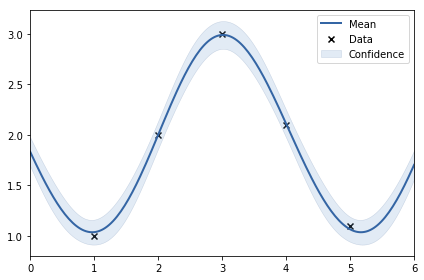

In [3]:
X = np.array([1, 2, 3, 4, 5]).reshape(-1, 1)
y = np.array([1, 2, 3, 2.1, 1.1]).reshape(-1, 1) 

ell = 1.5
p = 2.1
sf  = 2.5**2
sn  = 0.1**2

k = StandardPeriodic(1, variance=sf, lengthscale=ell, period=p)

gpml_result = np.array([
    [6.25000000000000, 2.58223848367638, 6.12780152746302, 2.68506896077807, 5.78549690475220],
    [2.58223848367638, 6.25000000000000, 2.58223848367638, 6.12780152746302, 2.68506896077807],
    [6.12780152746302, 2.58223848367638, 6.25000000000000, 2.58223848367638, 6.12780152746302],
    [2.68506896077807, 6.12780152746302, 2.58223848367638, 6.25000000000000, 2.58223848367638],
    [5.78549690475220, 2.68506896077807, 6.12780152746302, 2.58223848367638, 6.25000000000000]])

# Test covariance matrix correctness
cov_mat = k.K(X, X)
assert np.allclose(cov_mat, gpml_result)

m = GPy.models.GPRegression(X, y, kernel=k, noise_var=sn)
m.optimize_restarts(100, verbose=False)
m.plot()

# Test negative log marginal likelihood correctness
gpml_nlml = 3.5900
assert np.isclose(gpml_nlml, -m.log_likelihood(), rtol=1e-03)